# 1 — Setup & imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

# 2 — Load dataset & basic EDA

In [2]:
kaggle_path = "/kaggle/input/housing-price-prediction"
if os.path.exists(kaggle_path):
    csvs = [os.path.join(kaggle_path, f) for f in os.listdir(kaggle_path) if f.lower().endswith(".csv")]
    if len(csvs) == 0:
        raise FileNotFoundError("No CSV files found in the Kaggle dataset folder: " + kaggle_path)
    data_path = csvs[0]
    df = pd.read_csv(data_path)
else:
    raise FileNotFoundError(f"Kaggle dataset path not found: {kaggle_path}.")
print("Shape:", df.shape)
possible_targets = ["price", "Price", "saleprice", "SalePrice", "Sale_Price", "target", "y"]
target = None
for t in possible_targets:
    if t in df.columns:
        target = t
        break
if target is None:
    numeric_cols_fallback = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols_fallback:
        raise ValueError("No numeric columns found to use as target.")
    target = df[numeric_cols_fallback].std().sort_values(ascending=False).index[0]
print("Selected target column:", target)
X = df.drop(columns=[target])
y = df[target]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Numeric features: {len(num_cols)}, Categorical features: {len(cat_cols)}")
print("Missing values per column (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))
display(df.head())

Shape: (545, 13)
Selected target column: price
Numeric features: 5, Categorical features: 7
Missing values per column (top 20):
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# 3 — Preprocessing and split

In [3]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (436, 12) Test shape: (109, 12)


# 4 — Baseline linear regression + diagnostics

LinearRegression (all features) -> MAE: 970043.404, MSE: 1754318687330.669, R2: 0.653


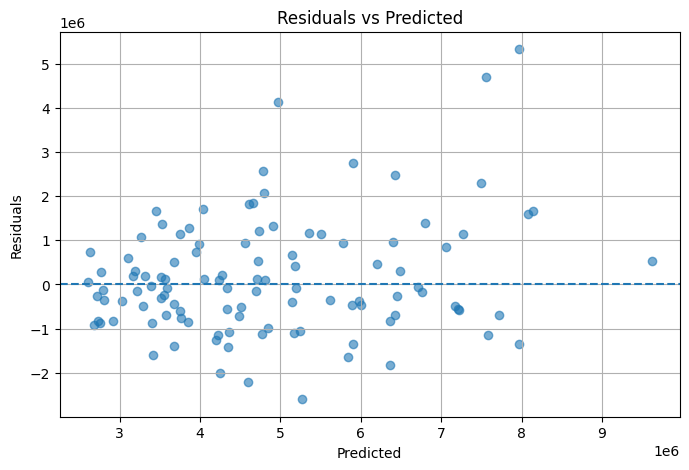

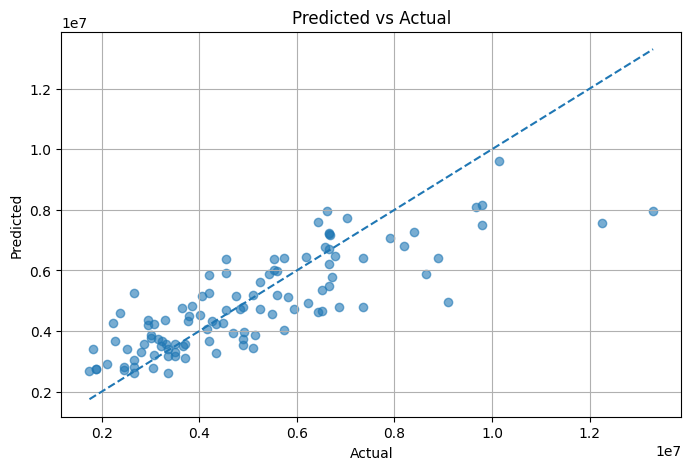

In [4]:
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
def print_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.3f}, MSE: {mse:.3f}, R2: {r2:.3f}")
print_metrics(y_test, y_pred_lr, "LinearRegression (all features)")
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,5))
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# 5 — VIF and regularization (Ridge/Lasso CV)

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_num_train = X_train[num_cols].copy()
X_num_train = X_num_train.fillna(X_num_train.median())
X_num_std = pd.DataFrame(StandardScaler().fit_transform(X_num_train), columns=num_cols)
vif_data = pd.DataFrame()
vif_data["feature"] = X_num_std.columns
vif_data["VIF"] = [variance_inflation_factor(X_num_std.values, i) for i in range(X_num_std.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)
display(vif_data.head(20))
param_grid_ridge = {'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_lasso = {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge())])
lasso_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(max_iter=10000))])
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_search = GridSearchCV(ridge_pipe, param_grid_ridge, cv=cv, scoring='r2', n_jobs=-1)
lasso_search = GridSearchCV(lasso_pipe, param_grid_lasso, cv=cv, scoring='r2', n_jobs=-1)
ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_search.best_params_['regressor__alpha'])
print("Best Lasso alpha:", lasso_search.best_params_['regressor__alpha'])
y_pred_ridge = ridge_search.predict(X_test)
y_pred_lasso = lasso_search.predict(X_test)
print_metrics(y_test, y_pred_ridge, "Ridge (best)")
print_metrics(y_test, y_pred_lasso, "Lasso (best)")
r2_lr = r2_score(y_test, y_pred_lr)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"R2 scores -> Linear: {r2_lr:.3f}, Ridge: {r2_ridge:.3f}, Lasso: {r2_lasso:.3f}")

,feature,VIF
1,bedrooms,1.332267
2,bathrooms,1.269826
3,stories,1.241431
0,area,1.157790
4,parking,1.154152


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Best Ridge alpha: 10.0
Best Lasso alpha: 0.01
Ridge (best) -> MAE: 975644.609, MSE: 1777303012708.854, R2: 0.648
Lasso (best) -> MAE: 970043.420, MSE: 1754318731758.992, R2: 0.653
R2 scores -> Linear: 0.653, Ridge: 0.648, Lasso: 0.653


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 6 — CV comparison, save best model, feature coefficients

In [6]:
models = {
    "Linear": model_lr,
    "Ridge_best": ridge_search.best_estimator_,
    "Lasso_best": lasso_search.best_estimator_
}
for name, m in models.items():
    scores = cross_val_score(m, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
    print(f"{name}: CV R2 (mean ± std): {scores.mean():.3f} ± {scores.std():.3f}")
best_model = ridge_search.best_estimator_
joblib.dump(best_model, "best_model.joblib")
print("Saved best_model.joblib")
def get_feature_names_from_preprocessor(preprocessor_obj):
    num_feats = num_cols
    cat_feats = []
    if len(cat_cols) > 0:
        ohe = preprocessor_obj.named_transformers_['cat'].named_steps['onehot']
        try:
            ohe_names = ohe.get_feature_names_out(cat_cols)
        except:
            ohe_names = [f"cat_{i}" for i in range(sum([1 for _ in cat_cols]))]
        cat_feats = list(ohe_names)
    return num_feats + cat_feats
preproc = best_model.named_steps['preprocessor']
reg = best_model.named_steps['regressor']
feat_names = get_feature_names_from_preprocessor(preproc)
coeffs = pd.Series(reg.coef_, index=feat_names).sort_values(key=abs, ascending=False)
display(coeffs.head(30))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Linear: CV R2 (mean ± std): 0.649 ± 0.045
Ridge_best: CV R2 (mean ± std): 0.651 ± 0.042
Lasso_best: CV R2 (mean ± std): 0.649 ± 0.045
Saved best_model.joblib


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

area                               515102.835977
bathrooms                          513781.374426
airconditioning_yes                374279.246278
airconditioning_no                -374279.246278
stories                            347888.947000
prefarea_no                       -298391.777946
prefarea_yes                       298391.777946
hotwaterheating_no                -269881.924661
hotwaterheating_yes                269881.924661
furnishingstatus_unfurnished      -225048.319601
parking                            198599.618312
basement_yes                       191036.103006
basement_no                       -191036.103006
mainroad_no                       -176522.850229
mainroad_yes                       176522.850229
furnishingstatus_furnished         174155.431843
guestroom_yes                      117406.348890
guestroom_no                      -117406.348890
bedrooms                            66158.325765
furnishingstatus_semi-furnished     50892.887758
dtype: float64